In [160]:
import os
import pandas as pd
import numpy as np
import pickle
import time
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize, RandomCrop, RandomHorizontalFlip, RandomRotation, ColorJitter, CenterCrop, ToTensor, Normalize, Compose
from torchvision.models import resnet18, resnet50

from sklearn.model_selection import StratifiedShuffleSplit
from tqdm.notebook import tqdm
from PIL import Image as PILImage
from PIL import ImageStat as PILImageStat

pd.options.mode.chained_assignment = None

name = 'parkers_brook'
data_dir = 'data'

site_dir = os.path.join(data_dir, name)
images_dir =  os.path.join(site_dir, 'images')
model_dir =  os.path.join(site_dir, 'model')
pred_dir =  os.path.join(site_dir, 'pred')

os.makedirs(model_dir, exist_ok=True)
os.makedirs(pred_dir, exist_ok=True)

In [88]:
df = pd.read_csv(os.path.join(site_dir, 'images.csv'), dtype={'flow_cfs': np.float32})
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_convert(tz='US/Eastern')
df['week'] = df['timestamp'].dt.isocalendar().week
df['year'] = df['timestamp'].dt.isocalendar().year
df.sort_values(by='timestamp', inplace=True, ignore_index=True)
df = df.sample(500, replace=False)
df

,filename,timestamp,flow_cfs,week,year
5089,20190806_1300_ParkersBrook.jpg,2019-08-06 09:00:00-04:00,3.43,32,2019
1427,20180929_1300_ParkersBrook.JPG,2018-09-29 09:00:00-04:00,11.75,39,2018
4747,20190704_1500_ParkersBrook.jpg,2019-07-04 11:00:00-04:00,4.91,27,2019
4329,20190602_1300_ParkersBrook.jpg,2019-06-02 09:00:00-04:00,7.86,22,2019
2244,20181209_1000_ParkersBrook.JPG,2018-12-09 05:00:00-05:00,13.98,49,2018
...,...,...,...,...,...
712,20180806_0800_ParkersBrook.JPG,2018-08-06 04:00:00-04:00,14.97,32,2018
903,20180821_0700_ParkersBrook.JPG,2018-08-21 03:00:00-04:00,15.11,34,2018
771,20180810_1400_ParkersBrook.JPG,2018-08-10 10:00:00-04:00,14.50,32,2018
741,20180808_1100_ParkersBrook.JPG,2018-08-08 07:00:00-04:00,12.55,32,2018


In [89]:
df.dtypes

filename                         object
timestamp    datetime64[ns, US/Eastern]
flow_cfs                        float32
week                             UInt32
year                             UInt32
dtype: object

In [90]:
weekly_flow_means = df[['flow_cfs', 'year', 'week']].groupby(['year', 'week']).mean().rename(columns={'flow_cfs': 'mean_flow_cfs'})
weekly_flow_means.head()

mean_flow_cfs
year week               
2018 24         3.800000
     25         3.633000
     26        15.288000
     27        11.696667
     28         9.670000

In [91]:
weekly_flow_quantiles = np.quantile(weekly_flow_means['mean_flow_cfs'].values, [.25, .75], axis=0)
weekly_flow_quantiles

array([ 7.21149981, 16.29299974])

In [92]:
def classify(low_value, high_value, value):
    if value <= low_value:
        return 'low'
    elif value >= high_value:
        return 'high'
    else:
        return 'med'

weekly_flow_means['flow_class'] = weekly_flow_means['mean_flow_cfs'].map(lambda x: classify(weekly_flow_quantiles[0], weekly_flow_quantiles[1], x))
weekly_flow_means['week_index'] = range(len(weekly_flow_means.index))

weekly_flow_means.head()

mean_flow_cfs flow_class  week_index
year week                                      
2018 24         3.800000        low           0
     25         3.633000        low           1
     26        15.288000        med           2
     27        11.696667        med           3
     28         9.670000        med           4

In [93]:
df_week = df.set_index(['year', 'week']).join(weekly_flow_means, on=['year', 'week']).reset_index()
df_week

,year,week,filename,timestamp,flow_cfs,mean_flow_cfs,flow_class,week_index
0,2019,32,20190806_1300_ParkersBrook.jpg,2019-08-06 09:00:00-04:00,3.43,3.768000,low,60
1,2018,39,20180929_1300_ParkersBrook.JPG,2018-09-29 09:00:00-04:00,11.75,11.540000,med,15
2,2019,27,20190704_1500_ParkersBrook.jpg,2019-07-04 11:00:00-04:00,4.91,7.483750,med,55
3,2019,22,20190602_1300_ParkersBrook.jpg,2019-06-02 09:00:00-04:00,7.86,9.632500,med,50
4,2018,49,20181209_1000_ParkersBrook.JPG,2018-12-09 05:00:00-05:00,13.98,16.886000,high,25
...,...,...,...,...,...,...,...,...
495,2018,32,20180806_0800_ParkersBrook.JPG,2018-08-06 04:00:00-04:00,14.97,21.090000,high,8
496,2018,34,20180821_0700_ParkersBrook.JPG,2018-08-21 03:00:00-04:00,15.11,7.286000,med,10
497,2018,32,20180810_1400_ParkersBrook.JPG,2018-08-10 10:00:00-04:00,14.50,21.090000,high,8
498,2018,32,20180808_1100_ParkersBrook.JPG,2018-08-08 07:00:00-04:00,12.55,21.090000,high,8


In [94]:
def image_resize(im, shape=None, scale=None): 
    if shape is None:
        r,c = im.size
        shape = (int(r*scale),int(c*scale))
    resized = im.resize(shape)
    return resized

# n_images = 100
# for filename in tqdm(df.head(n_images)['filename'], total=n_images):
#     raw_path = os.path.join(images_dir, filename)
#     new_path = os.path.join(resized_dir, filename)
#     if not os.path.exists(new_path):
#         image_resize(PILImage.open(raw_path), shape=(640,480)).save(new_path)

In [95]:
# df_week['rgb_mean'] = [
#     np.mean(PILImageStat.Stat(PILImage.open(os.path.join(images_dir, filename))).mean)
#     for filename in tqdm(df_week['filename'].values)
# ]
# df_week['rgb_mean'].hist()

In [96]:
min_hour = 7
max_hour = 18
df_week_filter = df_week[df_week['timestamp'].dt.hour.between(min_hour, max_hour)]
        
min_month = 1
max_month = 12
df_week_filter = df_week_filter[df_week_filter['timestamp'].dt.month.between(min_month, max_month)]

# min_rgb = 90
# df_week_filter = df_week_filter[df_week_filter['rgb_mean'] >= min_rgb]

len(df_week_filter) / len(df_week)

0.63

In [97]:
# weeks = avery.table[['flow_class', 'year', 'week', 'week_index']].drop_duplicates()
weeks = weekly_flow_means.reset_index()
random_seed = 12
test_ratio = 0.1
val_ratio = 0.1

X = weeks['week_index']
y = weeks['flow_class']

sss_test = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio, random_state=random_seed)
trainval_idx, test_idx = list(sss_test.split(X, y))[0]
sss_val = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio / (1 - test_ratio), random_state=random_seed)
train_idx, val_idx = list(sss_test.split(trainval_idx, y[trainval_idx]))[0]

weeks['split'] = weeks['week_index'].map(lambda x: 'train' if x in trainval_idx[train_idx] else 'val' if x in trainval_idx[val_idx] else 'test')
weeks.head(10)

,year,week,mean_flow_cfs,flow_class,week_index,split
0,2018,24,3.800000,low,0,test
1,2018,25,3.633000,low,1,train
2,2018,26,15.288000,med,2,train
3,2018,27,11.696667,med,3,val
4,2018,28,9.670000,med,4,train
5,2018,29,15.221250,med,5,train
6,2018,30,18.490000,high,6,train
7,2018,31,16.830000,high,7,train
8,2018,32,21.090000,high,8,train
9,2018,33,18.945715,high,9,train


In [98]:
weeks.groupby(['flow_class']).size() / len(weeks.index) * 100

flow_class
high    25.0
low     25.0
med     50.0
dtype: float64

In [99]:
weeks.groupby(['split', 'flow_class']).size()

split  flow_class
test   high           2
       low            2
       med            4
train  high          14
       low           14
       med           29
val    high           2
       low            2
       med            3
dtype: int64

In [100]:
df_train = df_week_filter[df_week_filter['week_index'].isin(trainval_idx[train_idx])]
df_val = df_week_filter[df_week_filter['week_index'].isin(trainval_idx[val_idx])]
df_test = df_week_filter[df_week_filter['week_index'].isin(test_idx)]
len(df_train), len(df_val), len(df_test)

(245, 29, 41)

In [101]:
df_train.groupby('flow_class').size()

flow_class
high     56
low      60
med     129
dtype: int64

In [102]:
df_test.groupby('flow_class').size()

flow_class
high     8
low      8
med     25
dtype: int64

In [103]:
df_val.groupby('flow_class').size()

flow_class
high     8
low      5
med     16
dtype: int64

In [104]:
class SiteDataset(Dataset):
    def __init__(self, table, images_dir, resize_size=[480,640], crop_size=[384,512],
                normalize=True, augment=True, training=True, means=None, stds=None, 
                crop_to_bbox=False, log_transform=False):
        self.table = table
        self.images_dir = images_dir
        self.resize_size = resize_size
        self.crop_size = crop_size
        self.normalize = normalize
        self.augment = augment
        self.training = training
        self.crop_to_bbox = crop_to_bbox
        self.log_transform = log_transform
    
    def __len__(self):
        return len(self.table)
    
    def get_image(self, index):
        """Loads image at given index"""
        path = os.path.join(images_dir, self.table.iloc[index]['filename'])
        return PILImage.open(path).convert('RGB')
    
    def compute_mean_std(self):
        """Compute RGB channel means and stds for image samples in the dataset."""
        means = np.zeros((3))
        stds = np.zeros((3))
        sample_size= min(len(self.table), 1000)
        sample_indices = np.random.choice(len(self.table), size=sample_size, replace=False)
        for idx in tqdm(sample_indices):
            img = self.get_image(idx)
            stat = PILImageStat.Stat(img)
            means += np.array(stat.mean)/255.0
            stds += np.array(stat.stddev)/255.0
        means = means/sample_size
        stds = stds/sample_size
        return means, stds
    
    def set_mean_std(self, means, stds):
        self.means = means
        self.stds = stds
    
    def crop_images_to_bboxes(self, crop_bool):
        self.crop_to_bbox = crop_bool
    
    def set_bbox_source(self, filename):
        self.bbox_file = filename
        with open(filename, 'rb') as handle:
            self.bboxes = pickle.load(handle)
    
    def create_transforms(self):
        """Create transforms to apply during training and evaluation.
        Transforms can involve data augmentation and/or normalization if desired.
        Data augmentation should only be applied during training, not during evaluation.
        """
        train_transforms = [Resize(self.resize_size)]
        if self.augment:
            train_transforms.append(RandomCrop(self.crop_size))
            train_transforms.append(RandomHorizontalFlip())
            train_transforms.append(RandomRotation(10))
            train_transforms.append(ColorJitter())
        else:
            train_transforms.append(CenterCrop(self.crop_size))
        train_transforms.append(ToTensor())
        if self.normalize:
            train_transforms.append(Normalize(self.means, self.stds))
        self.train_transform = Compose(train_transforms)
        
        eval_transforms = [Resize(self.resize_size)]
        eval_transforms.append(CenterCrop(self.crop_size))
        eval_transforms.append(ToTensor())
        if self.normalize:
            eval_transforms.append(Normalize(self.means, self.stds))
        self.eval_transform = Compose(eval_transforms)
    
    def train(self):
        self.training = True
    
    def evaluate(self):
        self.training = False
    
    def __getitem__(self, idx):
        img = self.get_image(idx)
        # crop image first
        if self.crop_to_bbox:
            image_table_index = self.table.index[idx]
            topleft_x, topleft_y, width, height = self.bboxes[image_table_index]
            bottomright_x = topleft_x + width
            bottomright_y = topleft_y + height
            img = img.crop((topleft_x, topleft_y, bottomright_x, bottomright_y))
        
        # apply transforms
        if self.training:
            sample = self.train_transform(img)
        else:
            sample = self.eval_transform(img)
        if not self.log_transform:
            label = self.table.iloc[idx]['flow_cfs']
        else:
            label = np.log(self.table.iloc[idx]['flow_cfs'])
        return sample, label

ds_train = SiteDataset(df_train, images_dir, training=True, normalize=True, augment=True, log_transform=True)
ds_val = SiteDataset(df_val, images_dir, training=False, normalize=True, augment=True, log_transform=True)
ds_test = SiteDataset(df_test, images_dir, training=False, normalize=True, augment=True, log_transform=True)

In [105]:
def compute_mean_std(df):
    """Compute RGB channel means and stds for image samples in the dataset."""
    means = np.zeros((3))
    stds = np.zeros((3))
    sample_size= min(len(df), 1000)
    sample_indices = np.random.choice(len(df), size=sample_size, replace=False)
    for idx in tqdm(sample_indices):
        path = os.path.join(images_dir, df.iloc[idx]['filename'])
        img = PILImage.open(path).convert('RGB')
        stat = PILImageStat.Stat(img)
        means += np.array(stat.mean)/255.0
        stds += np.array(stat.stddev)/255.0
    means = means/sample_size
    stds = stds/sample_size
    return means, stds

m,s = compute_mean_std(df_train)
ds_train.set_mean_std(m, s)
ds_val.set_mean_std(m, s)
ds_test.set_mean_std(m, s)

  0%|          | 0/245 [00:00<?, ?it/s]

In [106]:
ds_train.create_transforms()
ds_val.create_transforms()
ds_test.create_transforms()

In [107]:
batch_size = 64
num_workers = 0
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=True, num_workers=num_workers)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [108]:
# if torch.backends.mps.is_available():
#     device = torch.device("mps")
# else:
#     device = torch.device("cpu")
device = torch.device("cpu")
device

device(type='cpu')

In [109]:
def get_output_shape(model, input_shape=(1,3,224,224)):
    x = torch.randn(*input_shape)
    out = model(x)
    return out.shape

class ResNet18(nn.Module):
    """PyTorch ResNet-18 architecture.
    Attributes:
        pretrained (bool): whether to use weights from network trained on ImageNet
        truncate (int): how many layers to remove from the end of the network
    """
    def __init__(self, pretrained=True, truncate=0):
        super(ResNet18, self).__init__()
        self.model = resnet18(pretrained=pretrained)
        if truncate > 0:
            self.model = nn.Sequential(*list(self.model.children())[:-truncate])

        self.model.eval()

    def forward(self, x):
        x = self.model(x)
        return x

class ResNetRegressionNet(nn.Module):
    def __init__(self, input_shape=(3, 384, 512), resnet_size=18, truncate=2, pretrained=True, num_hlayers=[256, 64]):
        super(ResNetRegressionNet, self).__init__()
        self.input_shape = input_shape
        self.input_nchannels = input_shape[0]
        self.input_height = input_shape[1]
        self.input_width = input_shape[2]
        
        if resnet_size == 50:
            self.resnetbody = ResNet50(pretrained=True, truncate=truncate)
        elif resnet_size == 18:
            self.resnetbody = ResNet18(pretrained=True, truncate=truncate)
        else:
            raise ValueError('Only resnet_size 50 or 18 are supported.')
        num_filters = get_output_shape(self.resnetbody, input_shape=(1,*input_shape))[1]
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

        self.fclayer_modules = [nn.Linear(num_filters, num_hlayers[0]), nn.ReLU()]
        for i in range(1, len(num_hlayers)):
            self.fclayer_modules.extend([nn.Linear(num_hlayers[i-1], num_hlayers[i]), nn.ReLU()])
        self.fclayer_modules.extend([nn.Linear(num_hlayers[-1], 1)])
        self.fclayers = nn.Sequential(*self.fclayer_modules)
    
    def forward(self, x):
        x = self.resnetbody(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fclayers(x)
        x = x.squeeze()
        return x

model = ResNetRegressionNet(input_shape=(3, 384, 512), resnet_size=18, truncate=2, pretrained=True)

/opt/homebrew/Caskroom/miniconda/base/envs/deepstreamflow/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/deepstreamflow/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [110]:
for p in list(model.children())[0].parameters():
    p.requires_grad = False
unfreeze_after = 2
model.to(device)

ResNetRegressionNet(
  (resnetbody): ResNet18(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d

In [111]:
class MSELoss(nn.Module):
    def __init__(self):
        super(MSELoss, self).__init__()
        self.loss = nn.MSELoss()
    
    def forward(self, input, target):
        output = self.loss(input, target)
        return output

class RankNetLoss(nn.Module):
    def __init__(self):
        super(RankNetLoss, self).__init__()
    
    def forward(self, inputs_i, inputs_j, targets):
        oij = inputs_i - inputs_j
        Pij = torch.sigmoid(oij)
        target_probs = 0.5*(targets + 1)
        bceloss = nn.BCELoss()
        loss = bceloss(Pij, target_probs)
        return loss
    
criterion = MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)

In [127]:
class PairwiseRankAccuracy(torch.nn.Module):
    def __init__(self):
        super(PairwiseRankAccuracy, self).__init__()
    
    def forward(self, outputs_i, outputs_j, targets, boundaries=[0.33, 0.66]):
        oij = outputs_i - outputs_j
        Pij = torch.sigmoid(oij)
        preds = torch.zeros_like(targets)
        preds = torch.where(Pij < boundaries[0], -1, preds)
        preds = torch.where(Pij > boundaries[1], 1, preds)
        # preds[(Pij>boundaries[1])] = 1
        # preds[(Pij<boundaries[0])] = -1
        total = targets.size(0)
        # correct = (preds == targets).sum()
        correct = torch.eq(preds, targets).sum()
        return 100*correct/float(total)
        # zeros = (Pij>=0.33).float()*(Pij<=0.66).float()
        # target_probs = 0.5*(targets + 1)

def fit(model, criterion, optimizer, train_dl, device, epoch_num=None, verbose=False):
    """Train model for one epoch.
    
    Args:
        model (torch.nn.Module): network to train
        criterion (torch.nn.Module): loss function(s) used to train network weights
        optimizer (torch.optim.Optimizer): algorithm used to optimize network weights
        train_dl (torch.utils.DataLoader): data loader for training set
        epoch_num (int): epoch number for logging
    
    Returns:
        batch_loss_logger.avg (float): average criterion loss per batch during training
    """
    print('Training')
    model.train() # ensure model is in train mode
    train_dl.dataset.train() # ensure train transforms are applied
    batch_loss_logger = MetricLogger()
    batch_time_logger = MetricLogger()
    
    print('Starting for loop')
    for bidx, batch in tqdm(enumerate(train_dl), total=len(train_dl)):
        
        batch_starttime = time.time()
        
        if isinstance(criterion, (torch.nn.MarginRankingLoss, RankNetLoss)):
            # paired inputs ->[model]-> paired outputs ->[criterion]-> value
            inputs1, inputs2, labels = batch
            if next(model.parameters()).is_cuda:
                inputs1 = inputs1.to(device)
                inputs2 = inputs2.to(device)
                labels = labels.to(device)
            optimizer.zero_grad()
            outputs1, outputs2 = model(inputs1, inputs2)
            loss = criterion(outputs1, outputs2, labels)
            batch_loss_logger.update(loss.item())
            loss.backward()
            optimizer.step()
        else:
            # inputs ->[model]-> outputs ->[criterion]-> value
            inputs, labels = batch
            if next(model.parameters()).is_cuda:
                inputs = inputs.to(device)
                labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            batch_loss_logger.update(loss.item())
            loss.backward()
            optimizer.step()
        
        batch_endtime = time.time()
        batch_time_logger.update(batch_endtime-batch_starttime)
        
        if verbose and (bidx%10 == 9):
            print(f"[Epoch {epoch_num} Batch {bidx}]\t{batch_time_logger.sum:.2f} s\t{batch_loss_logger.avg:.4f}")
    
    print(f"[Epoch {epoch_num}]\t{batch_time_logger.sum:.2f} s\t{batch_loss_logger.avg:.4f}")
    
    return batch_loss_logger.avg

def validate(model, criterions, dl, device):
    """Calculate multiple criterion for a model on a dataset."""
    print('Validating')
    model.eval()
    dl.dataset.evaluate()
    criterion_loggers = [MetricLogger() for i in range(len(criterions))]
    with torch.no_grad(): # ensure no gradients are computed
        for bidx, batch in tqdm(enumerate(dl), total=len(dl)):
            model_outputs = {}
            for i, c in enumerate(criterions):
                # start_timer = time.time()
                if isinstance(c, (torch.nn.MarginRankingLoss, RankNetLoss, PairwiseRankAccuracy)):
                    # paired inputs ->[model]-> paired outputs ->[criterion]-> value
                    if 'outputs1' not in model_outputs.keys():
                        # store model outputs from forward pass in case another criterion needs the same
                        inputs1, inputs2, labels = batch
                        if next(model.parameters()).is_cuda:
                            inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
                        outputs1, outputs2 = model(inputs1, inputs2)
                        model_outputs['outputs1'] = outputs1
                        model_outputs['outputs2'] = outputs2
                    else:
                        # load previously computed model outputs from forward pass
                        outputs1, outputs2 = model_outputs['outputs1'], model_outputs['outputs2']
                    cval = c(outputs1, outputs2, labels)
                else:
                    # inputs ->[model]-> outputs ->[criterion]-> value
                    if 'outputs' not in model_outputs.keys():
                        # store model outputs from forward pass in case another criterion needs the same
                        inputs, labels = batch
                        if next(model.parameters()).is_cuda:
                            inputs, labels = inputs.to(device), labels.to(device)
                        outputs = model(inputs)
                        model_outputs['outputs'] = outputs
                    else:
                        # load previously computed model outputs from forward pass
                        outputs = model_outputs['outputs']
                    cval = c(outputs, labels)
                criterion_loggers[i].update(cval.item())
    return [cl.avg for cl in criterion_loggers]

class MetricLogger(object):
    """Computes and tracks the average and current value of a metric.
    
    Attributes:
        val: current value
        sum: sum of all logged values
        count: number of logged values
        avg: average of all logged values
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.count += n
        self.sum += val * n
        self.avg = self.sum / self.count


In [128]:
metriclogs = {}
metriclogs['training_loss'] = []
metriclogs['val_loss'] = []
metriclogs['test_loss'] = []

paramstrings = []
paramstrings.append('regression')
paramstrings.append(name)
paramstrings.append('augment')
paramstrings.append('normalize')
paramstr = '_'.join(paramstrings)

n_epochs = 15
for epoch in range(n_epochs):
    # train
    start_time = time.time()
    avg_loss_training = fit(model, criterion, optimizer, dl_train, device, epoch_num=epoch)
    stop_time = time.time()
    print('training epoch took %0.1f s'%(stop_time-start_time))
    metriclogs['training_loss'].append(avg_loss_training)

    # validate on val set
    start_time = time.time()
    valset_eval = validate(model, [criterion], dl_val, device)
    stop_time = time.time()
    print('valset eval took %0.1f s'%(stop_time-start_time))
    metriclogs['val_loss'].append(valset_eval[0])

    # validate on test set (peeking)
    start_time = time.time()
    testset_eval = validate(model, [criterion], dl_test, device)
    stop_time = time.time()
    print('testset eval took %0.1f s'%(stop_time-start_time))
    metriclogs['test_loss'].append(testset_eval[0])

    # update lr scheduler
    scheduler.step(valset_eval[0])

    # periodically save model checkpoints
    epoch_checkpoint_file = './epoch%d_'%epoch + '.ckpt'
    epoch_checkpoint_save_path = os.path.join(model_dir, epoch_checkpoint_file)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'training_loss': avg_loss_training,
        }, epoch_checkpoint_save_path)

    #  after [unfreeze_after] epochs, unfreeze the pretrained body network parameters
    if (epoch+1) == unfreeze_after:
        print('UNFREEZING CNN BODY')
        for p in list(model.children())[0].parameters():
            p.requires_grad = True

# save losses and any other metrics tracked during training
metrics_file = 'metrics_per_epoch_'+ paramstr + '.pkl'
metrics_save_path = os.path.join('.', metrics_file)
with open(metrics_save_path, 'wb') as f:
    pickle.dump(metriclogs, f, protocol=pickle.HIGHEST_PROTOCOL)

Training
Starting for loop


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 0]	45.01 s	0.6872
training epoch took 56.5 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

valset eval took 4.1 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

testset eval took 5.6 s
Training
Starting for loop


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 1]	45.45 s	0.7717
training epoch took 57.0 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

valset eval took 4.1 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

testset eval took 5.5 s
UNFREEZING CNN BODY
Training
Starting for loop


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 2]	44.94 s	0.6041
training epoch took 56.5 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

valset eval took 4.1 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

testset eval took 5.6 s
Training
Starting for loop


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 3]	45.21 s	0.3120
training epoch took 56.7 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

valset eval took 4.1 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

testset eval took 5.5 s
Training
Starting for loop


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 4]	45.30 s	0.3742
training epoch took 56.8 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

valset eval took 4.1 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

testset eval took 5.5 s
Training
Starting for loop


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 5]	45.20 s	0.3311
training epoch took 56.8 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

valset eval took 4.0 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

testset eval took 5.5 s
Training
Starting for loop


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 6]	44.74 s	0.2508
training epoch took 56.2 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

valset eval took 4.1 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

testset eval took 5.6 s
Training
Starting for loop


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 7]	44.83 s	0.2528
training epoch took 56.3 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

valset eval took 4.0 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

testset eval took 5.5 s
Training
Starting for loop


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 8]	45.31 s	0.2511
training epoch took 56.8 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

valset eval took 4.0 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

testset eval took 5.6 s
Training
Starting for loop


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 9]	44.45 s	0.2339
training epoch took 55.9 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

valset eval took 4.2 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

testset eval took 5.5 s
Training
Starting for loop


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 10]	44.71 s	0.2272
training epoch took 56.2 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

valset eval took 4.2 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

testset eval took 5.7 s
Training
Starting for loop


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 11]	45.04 s	0.2030
training epoch took 56.5 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

valset eval took 4.1 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

testset eval took 5.5 s
Training
Starting for loop


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 12]	44.67 s	0.2005
training epoch took 56.1 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

valset eval took 4.1 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

testset eval took 5.6 s
Training
Starting for loop


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 13]	44.81 s	0.2030
training epoch took 56.3 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

valset eval took 4.1 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

testset eval took 5.6 s
Training
Starting for loop


  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 14]	44.44 s	0.1914
training epoch took 55.9 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

valset eval took 4.1 s
Validating


  0%|          | 0/1 [00:00<?, ?it/s]

testset eval took 5.5 s


In [142]:
df_metrics = pd.DataFrame(data=metriclogs)
df_metrics['epoch'] = df_metrics.index
df_metrics = df_metrics.set_index('epoch')
df_metrics

,training_loss,val_loss,test_loss
epoch,,,
0,0.687162,0.586665,0.483516
1,0.771719,0.625346,0.519164
2,0.604068,0.309595,0.214372
3,0.312005,0.351096,0.255385
4,0.374152,0.409360,0.309256
5,0.331122,0.317775,0.218138
6,0.250779,0.248382,0.147546
7,0.252793,0.238105,0.135416
8,0.251063,0.238422,0.134619


<AxesSubplot:xlabel='epoch'>

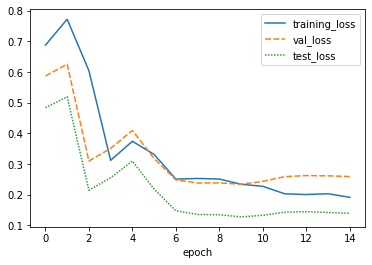

In [145]:
sns.lineplot(data=df_metrics)

In [146]:
dl_train2 = DataLoader(ds_train, batch_size=batch_size, shuffle=False, num_workers=0)
dl_val2 = DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=0)
dl_test2 = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=0)

In [150]:
ckpt_path = os.path.join(model_dir, f'epoch{n_epochs - 1}_.ckpt')
checkpoint = torch.load(ckpt_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

ResNetRegressionNet(
  (resnetbody): ResNet18(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d

In [166]:
for dl in [dl_train2, dl_val2, dl_test2]:
        dl.dataset.evaluate()
        scores = np.empty((len(dl.dataset),))
        sidx = 0
        with torch.no_grad():
            for bidx, batch in tqdm(enumerate(dl), total=len(dl)):
                inputs, labels = batch
                nsamples = labels.shape[0]
                outputs = model(inputs.to(device))
                scores[sidx:sidx+nsamples] = outputs.detach().cpu().numpy()
                sidx += nsamples
        dl.dataset.table.loc[:,'preds'] = np.exp(scores)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [187]:
train_pred_f = 'pred_train.csv'
train_pred_save_path = os.path.join(pred_dir, train_pred_f)
dl_train2.dataset.table.to_csv(train_pred_save_path)

val_pred_f = 'pred_val.csv'
val_pred_save_path = os.path.join(pred_dir, val_pred_f)
dl_val2.dataset.table.to_csv(val_pred_save_path)

test_pred_f = 'pred_test.csv'
test_pred_save_path = os.path.join(pred_dir, test_pred_f)
dl_test2.dataset.table.to_csv(test_pred_save_path)

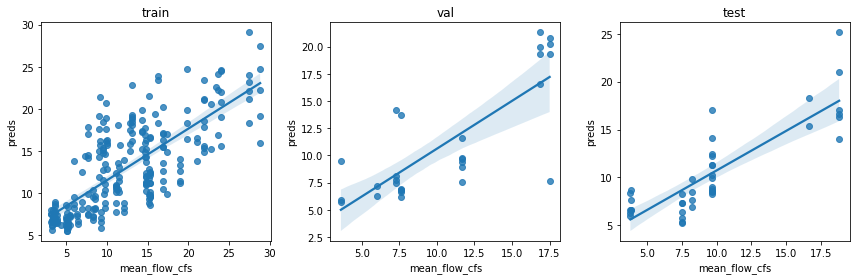

In [188]:
f, axs = plt.subplots(1, 3, figsize=(12, 4))
sns.regplot(x=dl_train2.dataset.table.mean_flow_cfs, y=dl_train2.dataset.table.preds, ax=axs[0]).set(title="train")
sns.regplot(x=dl_val2.dataset.table.mean_flow_cfs, y=dl_val2.dataset.table.preds, ax=axs[1]).set(title="val")
sns.regplot(x=dl_test2.dataset.table.mean_flow_cfs, y=dl_test2.dataset.table.preds, ax=axs[2]).set(title="test")
f.tight_layout()

In [189]:
dl_train2.dataset.table

,year,week,filename,timestamp,flow_cfs,mean_flow_cfs,flow_class,week_index,preds
1,2018,39,20180929_1300_ParkersBrook.JPG,2018-09-29 09:00:00-04:00,11.750000,11.540000,med,15,11.383570
5,2019,42,20191015_1400_ParkersBrook.jpg,2019-10-15 10:00:00-04:00,6.220000,5.924000,low,70,8.280393
6,2018,29,20180717_1900_ParkersBrook.JPG,2018-07-17 15:00:00-04:00,45.389999,15.221250,med,5,21.587089
8,2019,19,20190510_1800_ParkersBrook.jpg,2019-05-10 14:00:00-04:00,15.110000,15.942500,med,47,19.374995
11,2018,36,20180909_1200_ParkersBrook.JPG,2018-09-09 08:00:00-04:00,2.880000,3.436250,low,12,7.153074
...,...,...,...,...,...,...,...,...,...
493,2018,25,20180621_1100_ParkersBrook.JPG,2018-06-21 07:00:00-04:00,3.160000,3.633000,low,1,6.847577
494,2019,13,20190331_1600_ParkersBrook.jpg,2019-03-31 12:00:00-04:00,22.590000,16.254000,med,41,23.447993
497,2018,32,20180810_1400_ParkersBrook.JPG,2018-08-10 10:00:00-04:00,14.500000,21.090000,high,8,13.785186
498,2018,32,20180808_1100_ParkersBrook.JPG,2018-08-08 07:00:00-04:00,12.550000,21.090000,high,8,16.593060


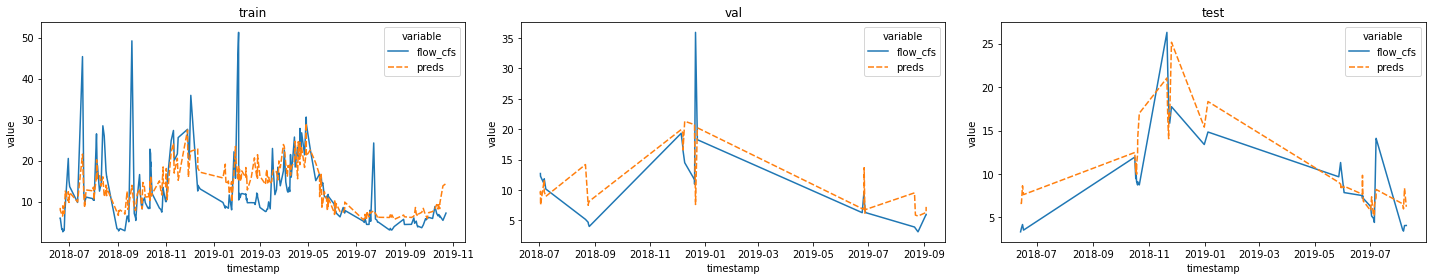

In [191]:
f, axs = plt.subplots(1, 3, figsize=(20, 4))
sns.lineplot(data=dl_train2.dataset.table.melt(id_vars=["timestamp"], value_vars=["flow_cfs","preds"]), x="timestamp", y="value", hue="variable", style="variable", linestyle="", ax=axs[0]).set(title="train")
sns.lineplot(data=dl_val2.dataset.table.melt(id_vars=["timestamp"], value_vars=["flow_cfs","preds"]), x="timestamp", y="value", hue="variable", style="variable", linestyle="", ax=axs[1]).set(title="val")
sns.lineplot(data=dl_test2.dataset.table.melt(id_vars=["timestamp"], value_vars=["flow_cfs","preds"]), x="timestamp", y="value", hue="variable", style="variable", linestyle="", ax=axs[2]).set(title="test")
f.tight_layout()